# Mask R-CNN - Compare ouptuts from Heatmap layer and FCN layer


In [24]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
%matplotlib inline
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('../')
import tensorflow as tf
import keras.backend as KB
import numpy as np
from mrcnn.datagen     import data_generator, load_image_gt
from mrcnn.callbacks   import get_layer_output_1,get_layer_output_2
from mrcnn.utils       import mask_string, parse_image_meta, apply_box_deltas_tf
from mrcnn.visualize   import display_gt_bboxes, display_roi_proposals, plot_gaussian, plot_gaussian2
from mrcnn.visualize   import display_gt_bboxes, display_roi_proposals
import mrcnn.visualize as visualize
from mrcnn.prep_notebook import prep_oldshapes_dev

model, dataset_train, train_generator, config = prep_oldshapes_dev(init_with = 'last', FCN_layers = True)
model_info = [model, config, dataset_train, train_generator]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
 Initialize config object - super
(56, 56)
>>> Initialize model WITHOUT MASKING LAYERS!!!!
    set_log_dir: Checkpoint path set to : E:\Models\mrcnn_development_logs\shapes20180519T1546\mask_rcnn_shapes_{epoch:04d}.h5
    set_log_dir: self.epoch set to 0 

>>> Resnet Graph 
     Input_image shape : (?, 128, 128, 3)
     After ZeroPadding2D  : (?, 134, 134, 3) (?, 134, 134, 3)
     After Conv2D padding : (?, 64, 64, 64) (?, 64, 64, 64)
     After BatchNorm      : (?, 64, 64, 64) (?, 64, 64, 64)
     After MaxPooling2D   : (?, 32, 32, 64) (?, 32, 32, 64)

>>> Feature Pyramid Network (FPN) Graph 
     FPN P2 shape : (None, 32, 32, 256)
     FPN P3 shape : (None, 16, 16, 256)
     FPN P4 shape : (None, 8, 8, 256)
     FPN P5 shape : (None, 4, 4, 256)
     FPN P6 shape : (None, 2, 2, 256)

>>> Generate pyramid anchors 
      Anchor  scales:   (8, 16, 32, 64, 128)
      Anchor  ratios:   [0.5, 1, 2]
     

     Prob_grid shape before tanspose:  (128, 128, ?)
     Prob_grid shape after tanspose:  (?, 128, 128)
    >> input to MVN.PROB: pos_grid (meshgrid) shape:  (128, 128, ?, 2)
    << output probabilities shape: (?, 128, 128)

    Scatter out the probability distributions based on class --------------
    pt2_ind shape   :  (?, 3)
    prob_grid shape :  (?, 128, 128)
    gauss_scatt     :  (5, 4, 100, 128, 128)

    Reduce sum based on class ---------------------------------------------
    gaussian_sum shape     :  (5, 4, 128, 128) Keras tensor  False

    L2 normalization ------------------------------------------------------
    gauss_norm   :  (5, 4, 128, 128)  Keras tensor  False
    in_tensor                (5, 4, 100, 6)
    in_tensorr_flattened is  (?, ?)
    boxes shape              (?, ?)
    Rois per image        :  100
    heatmap expanded shape : (5, 4, 1, 128, 128)
    heatmap original shape  :  (5, 4, 128, 128)
    heatmap replicated      :  (5, 4, 100, 128, 128)
    heat

In [25]:
train_batch_x, train_batch_y = next(train_generator)


>>> Generate pyramid anchors 
      Anchor  scales:   (8, 16, 32, 64, 128)
      Anchor  ratios:   [0.5, 1, 2]
      Anchor  stride:   1
      Feature shapes:   [[32 32]
 [16 16]
 [ 8  8]
 [ 4  4]
 [ 2  2]]
      Feature strides:  [4, 8, 16, 32, 64]
>>> generate_anchors()   Scale(s):  [8 8 8] Ratios:  [0.5 1.  2. ]  Heights:  [11.3137  8.      5.6569] Widths:  [ 5.6569  8.     11.3137]
>>> generate_anchors()   Scale(s):  [16 16 16] Ratios:  [0.5 1.  2. ]  Heights:  [22.6274 16.     11.3137] Widths:  [11.3137 16.     22.6274]
>>> generate_anchors()   Scale(s):  [32 32 32] Ratios:  [0.5 1.  2. ]  Heights:  [45.2548 32.     22.6274] Widths:  [22.6274 32.     45.2548]
>>> generate_anchors()   Scale(s):  [64 64 64] Ratios:  [0.5 1.  2. ]  Heights:  [90.5097 64.     45.2548] Widths:  [45.2548 64.     90.5097]
>>> generate_anchors()   Scale(s):  [128 128 128] Ratios:  [0.5 1.  2. ]  Heights:  [181.0193 128.      90.5097] Widths:  [ 90.5097 128.     181.0193]
    Size of anchor array is : (40

Image id:  99
Image meta [ 99 128 128   3   0   0 128 128   1   1   1   1]
Classes (1: circle, 2: square, 3: triangle ):  [2 1 1]


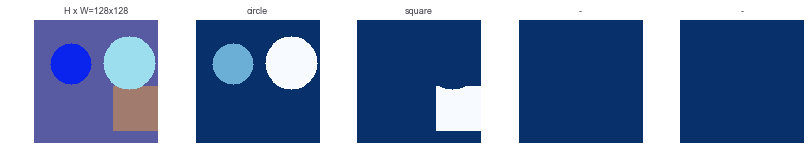

Image id:  109
Image meta [109 128 128   3   0   0 128 128   1   1   1   1]
Classes (1: circle, 2: square, 3: triangle ):  [3 2 1]


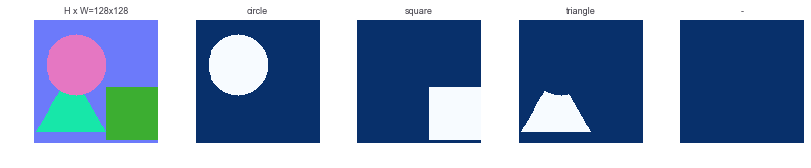

Image id:  107
Image meta [107 128 128   3   0   0 128 128   1   1   1   1]
Classes (1: circle, 2: square, 3: triangle ):  [1 3 1]


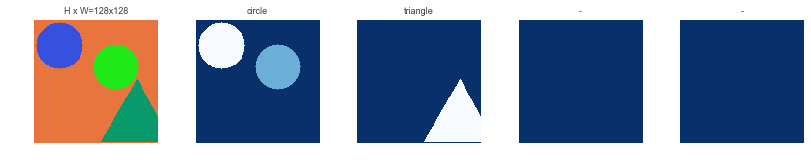

Image id:  88
Image meta [ 88 128 128   3   0   0 128 128   1   1   1   1]
Classes (1: circle, 2: square, 3: triangle ):  [1 2]


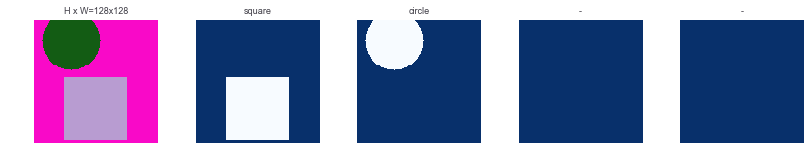

Image id:  34
Image meta [ 34 128 128   3   0   0 128 128   1   1   1   1]
Classes (1: circle, 2: square, 3: triangle ):  [2]


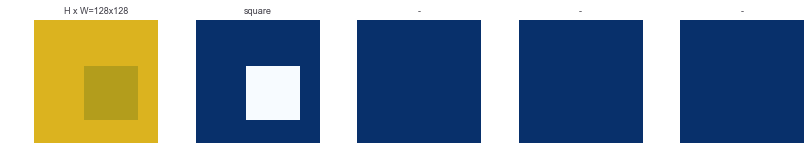

In [26]:
# train_batch_x, train_batch_y = next(train_generator)
imgmeta_idx = model.keras_model.input_names.index('input_image_meta')
img_meta    = train_batch_x[imgmeta_idx]

for img_idx in range(config.BATCH_SIZE):
    image_id = img_meta[img_idx,0]
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    print('Image id: ',image_id)
    print('Image meta', img_meta[img_idx])
    print('Classes (1: circle, 2: square, 3: triangle ): ',class_ids)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

In [27]:
model.layer_info()
# model.keras_model.outputs[0].name



 Inputs:
 -------
 layer:  0    output : input_image:0                              Type: float32           Shape: (?, 128, 128, 3)
 layer:  1    output : input_image_meta:0                         Type: float32           Shape: (?, ?)
 layer:  2    output : input_rpn_match:0                          Type: int32             Shape: (?, ?, 1)
 layer:  3    output : input_rpn_bbox:0                           Type: float32           Shape: (?, ?, 4)
 layer:  4    output : input_gt_class_ids:0                       Type: int32             Shape: (?, ?)
 layer:  5    output : input_gt_boxes:0                           Type: float32           Shape: (?, ?, 4)
 layer:  6    output : input_gt_masks:0                           Type: bool              Shape: (?, 56, 56, ?)


 Outputs:
 --------
 layer:  0    output : rpn_class_logits/concat:0                  Type: float32           Shape: (?, ?, 2)
 layer:  1    output : rpn_class/concat:0                         Type: float32           Shape:

### Push Data thru model using get_layer_output()

In [29]:

# model_output = get_layer_output_2(model.keras_model, train_batch_x, 1)
model_output = get_layer_output_1(model.keras_model, train_batch_x, [ 15,16,17,18,19,20,21,22,23], 1)


/* Inputs */
Input  0:  (input_image:0                           ) 	  Input shape: (5, 128, 128, 3)
Input  1:  (input_image_meta:0                      ) 	  Input shape: (5, 12)
Input  2:  (input_rpn_match:0                       ) 	  Input shape: (5, 4092, 1)
Input  3:  (input_rpn_bbox:0                        ) 	  Input shape: (5, 256, 4)
Input  4:  (input_gt_class_ids:0                    ) 	  Input shape: (5, 100)
Input  5:  (input_gt_boxes:0                        ) 	  Input shape: (5, 100, 4)
Input  6:  (input_gt_masks:0                        ) 	  Input shape: (5, 56, 56, 100)

/* Outputs */
Output idx:  0    Layer: 15: (cntxt_layer/pred_heatmap_norm:0         ) 	  Output shape: (5, 128, 128, 4)
Output idx:  1    Layer: 16: (cntxt_layer/gt_heatmap_norm:0           ) 	  Output shape: (5, 128, 128, 4)
Output idx:  2    Layer: 17: (cntxt_layer/pred_heatmap_scores:0       ) 	  Output shape: (5, 4, 32, 10)
Output idx:  3    Layer: 18: (cntxt_layer/gt_heatmap_scores:0         ) 	  Out

### Input Values

In [ ]:
# 0      Tensor("input_image:0", shape=(?, 128, 128, 3), dtype=float32)
# 1      Tensor("input_image_meta:0", shape=(?, ?), dtype=float32)
# 2      Tensor("input_rpn_match:0", shape=(?, ?, 1), dtype=int32)
# 3      Tensor("input_rpn_bbox:0", shape=(?, ?, 4), dtype=float32)
# 4      Tensor("input_gt_class_ids:0", shape=(?, ?), dtype=int32)
# 5      Tensor("input_gt_boxes:0", shape=(?, ?, 4), dtype=float32)
# 6      Tensor("input_gt_masks:0", shape=(?, 56, 56, ?), dtype=bool)

input_image_meta =  train_batch_x[1]
input_rpn_match  =  train_batch_x[2]
input_rpn_bbox   =  train_batch_x[3]
input_gt_class_ids = train_batch_x[4]
input_gt_bboxes = train_batch_x[5]
# gt_masks   =  train_batch_x[6]
print(' input_rpn_match    ', input_rpn_match.shape)
print(' input_rpn_bbox     ', input_rpn_bbox.shape)
print(' input_gt_class_ids ', input_gt_class_ids.shape)
print(' input_gt_bboxes    ', input_gt_bboxes.shape)


In [30]:
print(len(model_output))
pred_heatmap_norm         = model_output[0]          # layer: 15   shape: (5, 128, 128, 4)
gt_heatmap_norm           = model_output[1]          # layer: 16   shape: (5, 128, 128, 4)
pred_heatmap_scores       = model_output[2]          # layer: 17   shape: (5, 4, 32, 10)
gt_heatmap_scores         = model_output[3]          # layer: 18   shape: (5, 4, 100, 10)
pred_tensor               = model_output[4]          # layer: 19   shape: (5, 4, 32, 6)
gt_tensor                 = model_output[5]          # layer: 20   shape: (5, 4, 100, 6)
fcn_heatmap               = model_output[6]          # layer: 21   shape: (5, 16, 16, 4)
fcn_heatmap_norm          = model_output[7]          # layer: 22   shape: (5, 128, 128, 4)
fcn_scores                = model_output[8]          # layer: 23   shape: (5, 4, 32, 13)
# print(type(model_output[4]))
# print(type(output_rois))
for i in model_output:
    print( i.shape)
# print(output_rois[0])    

9
(5, 128, 128, 4)
(5, 128, 128, 4)
(5, 4, 32, 10)
(5, 4, 100, 10)
(5, 4, 32, 6)
(5, 4, 100, 6)
(5, 16, 16, 4)
(5, 128, 128, 4)
(5, 4, 32, 13)



## Plot Predicted and Ground Truth Probability Heatmaps `pred_gaussian` and `gt_gaussian` (Tensorflow)

`pred_gaussian2` and `gt_gaussian2` from Tensorflow PCN layer

In [ ]:
%matplotlib notebook
from mrcnn.visualize import plot_gaussian
# gt_heatmap  = layers_out[27]     # gt_gaussiam 
# pred_heatmap= layers_out[24]  # pred_gaussian
# gt_heatmap  = layers_out[19]     # gt_gaussiam 
# pred_heatmap= layers_out[18]  # pred_gaussian
print('gt_gaussian heatmap shape : ', gt_heatmap_norm.shape, ' pred_gaussian heatmap shape: ', pred_heatmap_norm.shape)
num_images = 1 # config.IMAGES_PER_GPU
num_classes = config.NUM_CLASSES

img = 0

image_id = input_image_meta[img,0]
print('Image id: ',image_id)
print('Classes (1: circle, 2: square, 3: triangle ): ')
image = dataset_train.load_image(image_id)
mask, class_ids = dataset_train.load_mask(image_id)
visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)


for cls in range(1,num_classes):
    ttl = 'GROUND TRUTH HEATMAP - image :  {} class: {} '.format(img,cls)
    print(' *** Zout  ', gt_heatmap_norm[img,:,:,cls].shape, ttl)   
    plot_gaussian( gt_heatmap_norm[img,:,:,cls], title = ttl)
    
    ttl = 'PREDICTED heatmap  - image :  {} class: {} '.format(img,cls)     
    print(' *** pred_heatmap ', pred_heatmap_norm[img,:,:,cls].shape, ttl)   
    plot_gaussian(pred_heatmap_norm[img,:,:,cls], title = ttl)  


In [ ]:
# print *_tensor / *_heatmap_scores
np.set_printoptions(linewidth=150, threshold=10000)
# print(' Pred tensor: ', pred_tensor.shape, 'gt_tensor:', gt_tensor.shape)
print(' Pred tensor: ', pred_heatmap_scores.shape, 'gt_tensor:', gt_heatmap_scores.shape)
# pt2_sum = tf.reduce_sum(tf.abs(in_tensor[:,:,:,:-1]), axis=-1)
# print(pred_tensor[2])
# print(gt_tensor[2])
# print(gt_heatmap_scores[2])
print(pred_heatmap_scores[2,0])
print(fcn_scores[2,0])

In [ ]:
for i in [2]:
    for cls in range(4):
        pred_tst = pred_heatmap[img,:,:,cls]
        gt_tst = gt_heatmap[img,:,:,cls]
        print(pred_tst.shape, gt_tst.shape)
        print('img/cls :', img,cls, 'pred sum : ',tf.reduce_sum(pred_tst).eval(), 'gt sum : ',tf.reduce_sum(gt_tst).eval())



### Plot heatmap produced by network `fcn_bilinear` and compare with `pred_gaussian`

In [ ]:
from mrcnn.visualize import plot_gaussian
import matplotlib as plt

%matplotlib notebook
img = 3
image_id = input_image_meta[img,0]
print('Image id: ',image_id)
print('Classes (1: circle, 2: square, 3: triangle ): ')
image = dataset_train.load_image(image_id)
mask, class_ids = dataset_train.load_mask(image_id)
visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)


Zout  = pred_heatmap_norm     # gt_gaussiam 
Zout2 = fcn_heatmap  # fcn_bilinear

print(Zout.shape, Zout2.shape)
num_images = config.IMAGES_PER_GPU
num_classes = config.NUM_CLASSES

width = 9
for cls in range(num_classes):
    ttl = 'FR-CNN      - image :  {} class: {} '.format(img,cls)
    print(' *** Zout  ', Zout[img,:,:,cls].shape, ttl)   
    plot_gaussian( Zout[img,:,:,cls], title = ttl, width = width)
    
    ttl = 'FCN_Bilinear - image :  {} class: {} '.format(img,cls)     
    print(' *** Zout2 ', Zout2[img,:,:,cls].shape, ttl)   
    plot_gaussian(Zout2[img,:,:,cls], title = ttl, width = width)  


In [ ]:
%matplotlib notebook
width = 12
plot_gaussian2([pred_heatmap_norm, fcn_heatmap_norm], image_idx = 0, title = ttl, width = width)  


###  - Compute mean/min/max of regular and  L2 normalized Pred, GT, and FCN heatmap tensors

In [ ]:
sess = KB.get_session()
with sess.as_default():
    fcn_masks  = KB.identity(fcn_heatmap)
    pred_masks = KB.identity(pred_heatmap_norm)
    gt_masks   = KB.identity(gt_heatmap_norm)
    shape = KB.int_shape(pred_masks)
    print(shape)

    pred_masks_r = tf.reshape(pred_masks, [shape[0], -1, shape[-1]])
    fcn_masks_r = tf.reshape(fcn_masks, [shape[0], -1, shape[-1]])
    gt_masks_r  = tf.reshape(gt_masks, [shape[0], -1, shape[-1]])

    print(gt_masks_r.shape, fcn_masks_r.shape)

    pred_mean2 = KB.mean(pred_masks_r, axis = 1).eval()
    pred_max2  =  KB.max(pred_masks_r, axis=1).eval()
    pred_min2  =  KB.min(pred_masks_r, axis=1).eval()

    gt_mean2 = KB.mean(gt_masks_r, axis = 1).eval()
    gt_max2  =  KB.max(gt_masks_r, axis=1).eval()
    gt_min2  =  KB.min(gt_masks_r, axis=1).eval()

    fcn_mean2 = KB.mean(fcn_masks_r, axis = 1).eval()
    fcn_max2  =  KB.max(fcn_masks_r, axis=1).eval()
    fcn_min2  =  KB.min(fcn_masks_r, axis=1).eval()    

    ##---------------------------------------------------------------------------------------------
    ## Compute L2 Normalizationof Pred, GT, and FCN tensors
    ##---------------------------------------------------------------------------------------------    
    pred_l2      = KB.l2_normalize(pred_masks_r, axis = 1)
    gt_l2        = KB.l2_normalize(gt_masks_r, axis = 1)
    fcn_l2       = KB.l2_normalize(fcn_masks_r, axis = 1)
    pred_l2_min  = KB.min(pred_l2, axis = 1).eval()
    pred_l2_max  = KB.max(pred_l2, axis = 1).eval()
    pred_l2_mean = KB.mean(pred_l2, axis = 1).eval()
    gt_l2_min    = KB.min(gt_l2, axis = 1).eval()
    gt_l2_max    = KB.max(gt_l2, axis = 1).eval()
    gt_l2_mean   = KB.mean(gt_l2, axis = 1).eval()
    fcn_l2_min   = KB.min(fcn_l2, axis = 1).eval()
    fcn_l2_max   = KB.max(fcn_l2, axis = 1).eval()
    fcn_l2_mean  = KB.mean(fcn_l2, axis = 1).eval()

    print(' Shape of L2 normalized tensor: ',pred_l2.shape, gt_l2.shape, fcn_l2.shape)
    print(' Shape of L2 min tensor       : ',pred_l2_min.shape, gt_l2_min.shape, fcn_l2_min.shape)
    print(' Shape of L2 max tensor       : ',pred_l2_max.shape, gt_l2_max.shape, fcn_l2_max.shape)
    print(' Shape of L2 mean tensor      : ',pred_l2_mean.shape, gt_l2_mean.shape, fcn_l2_mean.shape)    

####  Print results of L2 normalization (Mean, Min , Max) vs. Original values

In [ ]:
for img in range(5):
    for cls in range(4):
        print('\n I/C:{}/{} '.format(img, cls))
        print('             Mean:  gt:{:.5e}  fcn:{: 11.5e}   pred: {:.6f}'\
              .format(gt_mean2[img,cls], fcn_mean2[img,cls], pred_mean2[img,cls]))
        print('          L2 Mean:  gt:{:.5e}  fcn:{: 11.5e}   pred: {:.6f}'\
              .format(gt_l2_mean[img,cls], fcn_l2_mean[img,cls], pred_l2_mean[img,cls]))
        print('             MAX:   gt:{:.5e}  fcn:{: 11.5e}   pred: {:.5e}' \
              .format(gt_max2[img,cls], fcn_max2[img,cls], pred_max2[img,cls]))
        print('          L2 MAX:   gt:{:.5e}  fcn:{: 11.5e}   pred: {:.5e}' \
              .format(gt_l2_max[img,cls], fcn_l2_max[img,cls], pred_l2_max[img,cls]))
        print('             MIN:   gt:{:.5e}  fcn:{: 11.5e}   pred: {:.5e}'\
              .format(gt_min2[img,cls], fcn_min2[img,cls], pred_min2[img,cls]))              
        print('          L2 MIN:   gt:{:.5e}  fcn:{: 11.5e}   pred: {:.5e}'\
              .format(gt_l2_min[img,cls], fcn_l2_min[img,cls], pred_l2_min[img,cls]))              

#### Print (Mean, Min , Max)  values

In [ ]:
print(gt_masks.shape, fcn_masks.shape)

for img in range(5):
    for cls in range(4):
        print('I/C: {}/{}  min/max     gt: [{:.5e} , {:.5e}]       pred: [{:.5e} , {:.5e}]     fcn:[{:.5e} , {:.5e}]   '\
              .format(img, cls,    gt_min2[img,cls], gt_max2[img,cls], pred_min2[img,cls], pred_max2[img,cls] ,
                                  fcn_min2[img,cls], fcn_max2[img,cls] ))    
        
print('\n\n')        
for img in range(5):
    for cls in range(4):
        print('I/C:{}/{}  Mean:  gt: {:.5e}   fcn : {:9.5e}   pred : {:.6f}   \t MAX: gt:{:.5e}  fcn:{:.5e}  pred: {:.5e}'\
              .format(img, cls, gt_mean2[img,cls], fcn_mean2[img,cls], pred_mean2[img,cls], 
                      gt_max2[img,cls], fcn_max2[img,cls], pred_max2[img,cls]))

In [ ]:
with sess.as_default():
    print(tf.shape(pred_masks).eval())
    shape = tf.shape(pred_masks).eval()
    pred_masks_r = tf.reshape(pred_masks, [shape[0], -1, shape[-1]])
    means = KB.mean(pred_masks_r, axis = 1)
    maxs  = KB.max(pred_masks_r, axis=1)

    # norms, means2, var = KB.normalize_batch_in_training(pred_masks[, 1.0, 0.0,[0,3])
    l2_norm = KB.l2_normalize (pred_masks_r,axis = 1)
    print(pred_masks.shape,pred_masks_r.shape)
    print(means.shape, maxs.shape)
    # print(' Shape of BN tensor: ', norms.shape)
    # print(' Shape of means2 tensor: ', means2.shape)
    # print(' Shape of var tensor: ', var.shape)
    print(' Shape of L2 normalized tensor: ',l2_norm.shape)
    print()
    np.set_printoptions(linewidth=130, threshold=20000, precision=6)
#     print('norms')
#     print(norms.eval())
    print('means')
    print(means.eval())
    print('maxs')
    print(maxs.eval())

In [ ]:
# pt   = layers_out[4]   # pred_gaussian 
# pt2  = layers_out[10]  # pred_gaussian_2
np.set_printoptions(linewidth=130, threshold=20000)
gt   =  np.transpose(pred_masks.eval(), [0,3,1,2])
gt2  =  np.transpose(p2.eval(), [0,3,1,2])
# gt   = np.where(gt > 1e-6,gt,0)
# gt2   = np.where(gt2 > 1e-6,gt2,0)
print( ' pt shape ', gt.shape, ' pt2.shape ', gt2.shape)

for img in range(config.BATCH_SIZE):
#     print(' from np ')
#     print(pt[img])
#     print(' from tensorflow')
#     print(pt2[img])
    for cls in range(4):
        equal = np.equal(gt2[img,cls,:,:] , gt[img, cls,:,:])
        print(equal.shape)
        print( 'Image ',img,' Class ',cls, '  all equal: ',equal.all())        
        print(equal.shape)
        
        if (~equal.all()):
            print('Not Equal: ',~equal)
            print( 'Image ',img,' Class ',cls, ' ALL EQUAL: ',equal.all())
#             print('\n -- using numpy      \n',  gt[img, cls, ~equal])
#             print('\n -- using tensorflow \n', gt2[img, cls, ~equal])
# if not equal display the different between the mismatching rows
            for i in range(equal.shape[0]):
                if ~equal[i]:
                    diff = np.abs(gt2[img, cls, i] - gt[img, cls, i])
                    big_error = np.any(diff > 3.0e-9, axis = -1)
                    print('   row = ', i, ' rows equal = ',equal[i], '   Big Error (larger than 7.0e-8): ' ,big_error)
                    if big_error:
                        print(' difference  :', diff )
#                     print(' -- using numpy      \n',gt[img,cls,i])            
#                     print(' -- using tensorflow \n',gt2[img,cls,i])

### Display ground truth bboxes from Shapes database (using `load_image_gt` )

Here we are displaying the ground truth bounding boxes as provided by the dataset

In [ ]:
from mrcnn.utils import display_gt_bboxes, dispaly_roi_bboxes
model_info = [model, config, dataset_train, train_generator]
display_gt_bboxes(model_info, input_image_meta, 0)

### Display Predicted  Ground Truth Bounding Boxes  `gt_tensor` and `gt_tensor2`

layers_out[22]  `gt_tensor` is based on input_gt_class_ids and input_normlzd_gt_boxes
layers_out[28]  `gt_tensor2` is based on input_gt_class_ids and input_normlzd_gt_boxes, generated using Tensorflow

Display the Ground Truth bounding boxes from the tensor we've constructed

In [ ]:
from mrcnn.utils  import stack_tensors, stack_tensors_3d
gt_bboxes_stacked = stack_tensors_3d(layers_out[23][img])

# print(gt_bboxes)
# visualize.display_instances(p_original_image, p_gt_bbox, p_gt_mask, p_gt_class_id, 
#                             dataset_train.class_names, figsize=(8, 8))
# pp.pprint(gt_bboxes)
img = 0
image_id = img_meta[img,0]

print('Image id: ',image_id)
p_image, p_image_meta, p_gt_class_id, p_gt_bbox, p_gt_mask =  \
            load_image_gt(dataset_train, config, image_id, augment=False, use_mini_mask=True)   

print(gt_bboxes_stacked)
visualize.draw_boxes(p_image, gt_bboxes_stacked[:,0:4])

### Display RoI proposals `pred_bboxes` generated for one class

Display bounding boxes from tensor of proposals produced by the network 
Square: 1 , Circle:2 , Triangle 3

In [ ]:
model_info = [model, config, dataset_train, train_generator]
display_roi_proposals(model_info, input_image_meta, pred_tensor, 0)